<a href="https://colab.research.google.com/github/sznajder/ON-Minicurso-2022/blob/main/AE_MNIST_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AUTOENCODER on MNIST digits**

In [3]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import numpy as np
import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import History, TensorBoard
#################################################

# Set training parameters
nepochs = 5
batchsize = 500

# AUTOENCODER( ENCODER-DECODER ) MODEL

# prepare our input data using MNIST digits discarding the labels (since we're only interested in encoding/decoding the input images)
# Loads the training and test data sets (ignoring class labels)
#(x_train, _), (x_test, _) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

# Data set consists 3D arrays with 60K training and 10K test images.
# with a resolution of 28 x 28 (pixels).
x_train.shape, x_test.shape
# ((60000, 28, 28), (10000, 28, 28))
# Reshape the 28 x 28 images into vectors of length 784
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
(x_train.shape, x_test.shape)
# ((60000, 784), (10000, 784))



((60000, 784), (10000, 784))

**Define the Autoencoder, Encoder and Decoder separetly**

In [4]:
# this is the size of our encoded representations
# input dimension = 784
input_dim = x_train.shape[1]
encoding_dim = 32
compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

# this is our input placeholder
input_img = Input(shape=(784,))

autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Dense(4 * encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))
autoencoder.summary()

####################################################

# ENCODER MODEL
input_img = Input(shape=(input_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))
encoder.summary()

# DECODER MODEL
encoded_img = Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder.layers[3]
decoder_layer2 = autoencoder.layers[4]
decoder_layer3 = autoencoder.layers[5]
decoder = Model(encoded_img, decoder_layer3(decoder_layer2(decoder_layer1(encoded_img))))
decoder.summary()

#####################################################

# Plot network topology/model
#plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True)

# TRAINING

# configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=["accuracy"]
                    )

#  train our autoencoder
auto = autoencoder.fit(x_train, x_train,
                       epochs=nepochs,
                       batch_size=batchsize,
                       shuffle=True,
                       validation_data=(x_test, x_test)
                       )




Compression factor: 24.5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136    
                                                                 
Total params: 222,384
Trainable

**Plot the original and the decoded image**

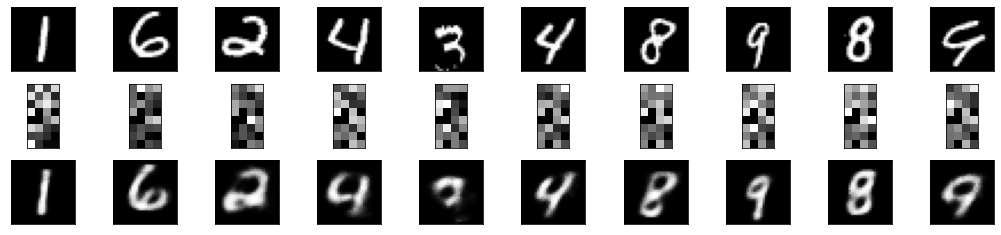

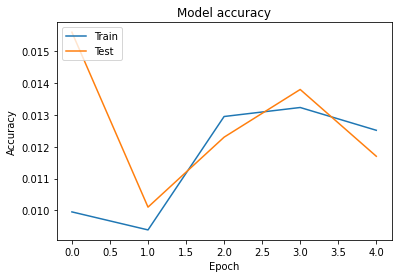

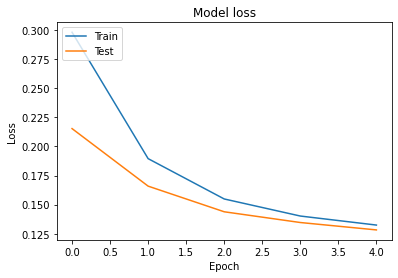

In [6]:
############################################################################
# Visualize the reconstructed inputs and the encoded representations
# encode and decode some digits ( note that we take them from the *test* set )

# use Matplotlib

num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
#decoded_imgs = autoencoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Plot of the digit classes in the latent space
#x_test_latent = encoder.predict(x_test, batch_size=batchsize)
#plt.figure(figsize=(6, 6))
#plt.scatter(x_test_latent[:, 0], x_test_latent[:, 1], c=y_test)
#plt.colorbar()
#plt.show()

#####################################################

# Plot training & validation accuracy values
plt.plot(auto.history['accuracy'])
plt.plot(auto.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(auto.history['loss'])
plt.plot(auto.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#
#####################################################################################
#
